Навчання моделі на CIFAR-10 з використанням VGG16

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchvision.models import VGG16_Weights

In [2]:
# Налаштування пристрою
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Завантаження та підготовка CIFAR-10
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # VGG16 очікує зображення 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Завантаження попередньо натренованої моделі VGG16
weights = VGG16_Weights.IMAGENET1K_V1  # Використання попередньо натренованих ваг
model = models.vgg16(weights=weights)

# Налаштування моделі для CIFAR-10
num_classes = 10
model.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)

model = model.to(device)

# Налаштування оптимізатора та метрики
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

100%|██████████| 170498071/170498071 [00:03<00:00, 47258326.12it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 137MB/s]


In [3]:
# Тренування моделі

num_epochs = 10
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Точність на тренувальних даних
    train_accuracy = 100 * correct / total
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Оцінка моделі на тестових даних
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(test_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.2f}%')

Epoch [1/10], Train Loss: 0.4381, Train Accuracy: 85.01%, Test Loss: 0.2708, Test Accuracy: 91.01%
Epoch [2/10], Train Loss: 0.1997, Train Accuracy: 93.24%, Test Loss: 0.2819, Test Accuracy: 90.78%
Epoch [3/10], Train Loss: 0.1209, Train Accuracy: 95.85%, Test Loss: 0.2955, Test Accuracy: 90.71%
Epoch [4/10], Train Loss: 0.0906, Train Accuracy: 96.91%, Test Loss: 0.3015, Test Accuracy: 91.31%
Epoch [5/10], Train Loss: 0.0698, Train Accuracy: 97.66%, Test Loss: 0.3116, Test Accuracy: 91.76%
Epoch [6/10], Train Loss: 0.0614, Train Accuracy: 97.94%, Test Loss: 0.3173, Test Accuracy: 91.45%
Epoch [7/10], Train Loss: 0.0517, Train Accuracy: 98.31%, Test Loss: 0.3187, Test Accuracy: 91.81%
Epoch [8/10], Train Loss: 0.0501, Train Accuracy: 98.40%, Test Loss: 0.3486, Test Accuracy: 91.00%
Epoch [9/10], Train Loss: 0.0447, Train Accuracy: 98.46%, Test Loss: 0.2833, Test Accuracy: 92.63%
Epoch [10/10], Train Loss: 0.0421, Train Accuracy: 98.67%, Test Loss: 0.2907, Test Accuracy: 92.76%


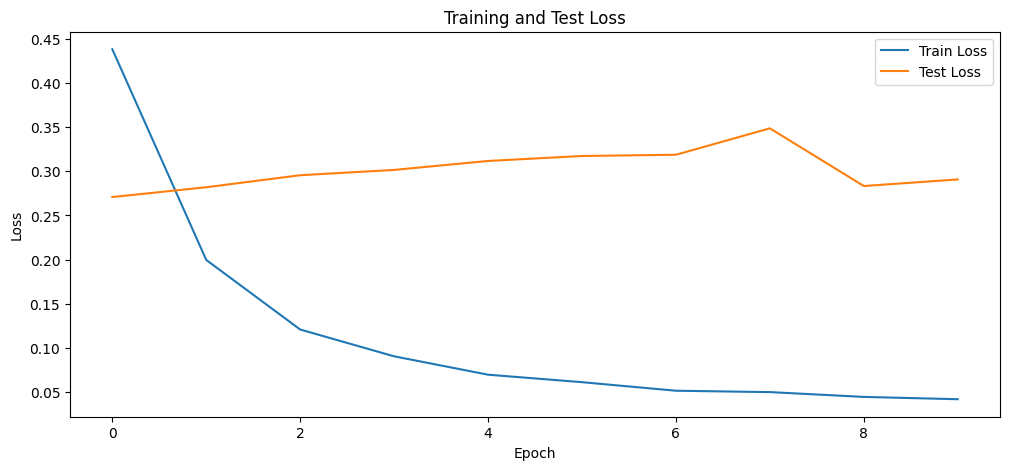

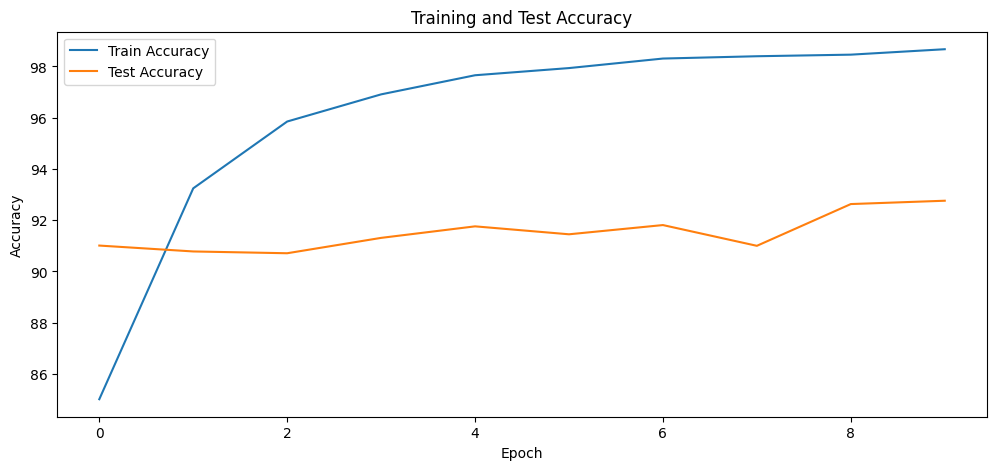

In [4]:
import matplotlib.pyplot as plt

# Графік втрат
plt.figure(figsize=(12, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Графік точності
plt.figure(figsize=(12, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

# Збереження моделі на Google Drive
model_save_path = '/content/drive/MyDrive/vgg16_cifar10.pth'
torch.save(model.state_dict(), model_save_path)

Mounted at /content/drive


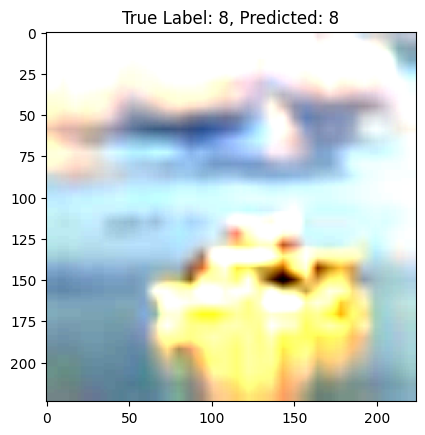

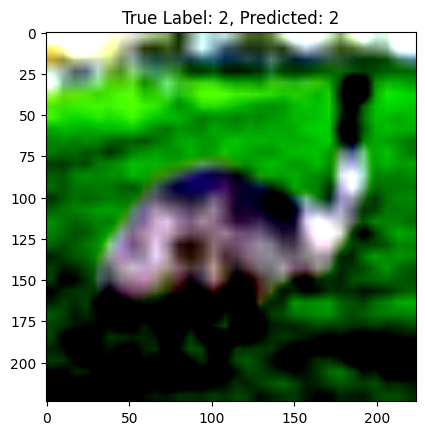

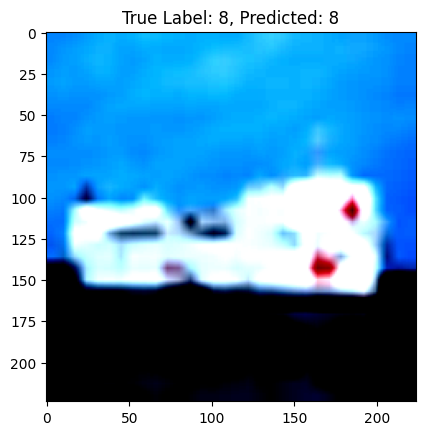

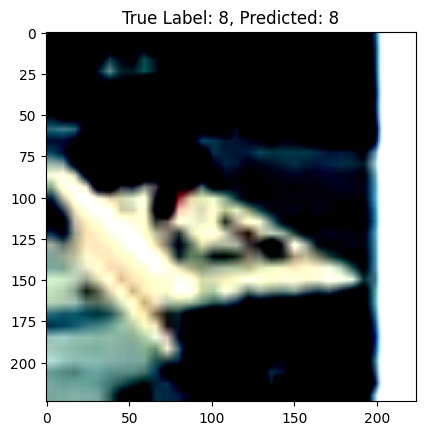

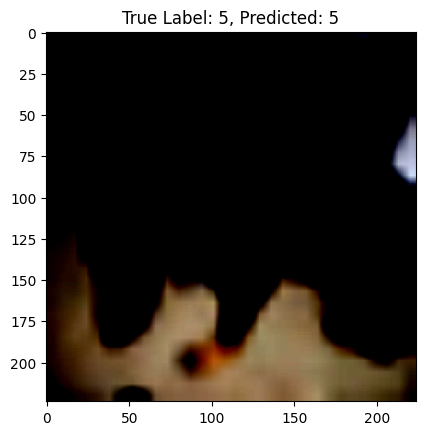

In [6]:
import random
import numpy as np

# Вибір кількох випадкових зображень з тестового датасету
num_samples = 5
random_indices = random.sample(range(len(test_dataset)), num_samples)
random_images, random_labels = zip(*[test_dataset[i] for i in random_indices])

model.eval()
with torch.no_grad():
    for i in range(num_samples):
        image = random_images[i].unsqueeze(0).to(device)
        label = random_labels[i]

        output = model(image)
        _, predicted = torch.max(output, 1)

        plt.imshow(np.transpose(random_images[i].cpu().numpy(), (1, 2, 0)))
        plt.title(f'True Label: {label}, Predicted: {predicted.item()}')
        plt.show()